In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# load csv files 
sim_temp_csv = '../outputs/bootstrap_results/daily_simulations_temperature.csv'
sim_precip_csv = '../outputs/bootstrap_results/daily_simulations_precipitation.csv'

# Load individual simulation dataframes
sim_temp = pd.read_csv(sim_temp_csv)
sim_precip = pd.read_csv(sim_precip_csv)

# Create unified dataframe with both temperature and precipitation simulations
sim_df = pd.concat([
    sim_temp.add_prefix('temp_'),
    sim_precip.add_prefix('precip_')
], axis=1)



In [2]:
# Get the number of simulations
n_sims = len([col for col in sim_df.columns if col.startswith('temp_')])

# Create an empty list to store DataFrames for each simulation
sim_dfs = []

# For each simulation, extract its temperature and precipitation data
for i in range(n_sims):
    # Format the simulation number as a 4-digit string
    sim_num = f'{i:04d}'
    temp_col = f'temp_sim_{sim_num}'
    precip_col = f'precip_sim_{sim_num}'
    
    # Create a DataFrame for this simulation
    sim_data = pd.DataFrame({
        'temperature': sim_df[temp_col],
        'precipitation': sim_df[precip_col]
    })
    
    # Add simulation number as index
    sim_data['simulation'] = i
    
    sim_dfs.append(sim_data)

# Concatenate all simulation DataFrames vertically
sim_df_reshaped = pd.concat(sim_dfs, axis=0).reset_index(drop=True)

# Display the first few rows of the reshaped dataframe
print("Shape of reshaped DataFrame:", sim_df_reshaped.shape)
sim_df_reshaped.head(10)


Shape of reshaped DataFrame: (365000, 3)


,temperature,precipitation,simulation
0,24.062653,0.000065,0
1,22.432343,0.000039,0
2,21.985382,0.000309,0
3,22.916473,0.000195,0
4,25.023071,0.000083,0
5,25.649078,0.000118,0
6,26.419098,0.000215,0
7,27.123200,0.001103,0
8,27.566315,0.000342,0
9,27.716461,0.000056,0


In [3]:
threshold_precipitation = 0.003
threshold_temperature = 30

sim_df_reshaped['event'] = np.where((sim_df_reshaped['temperature'] > threshold_temperature) & (sim_df_reshaped['precipitation'] > threshold_precipitation), 1, 0)
np.round(sim_df_reshaped['event'].value_counts()[1] / sim_df_reshaped['event'].value_counts()[0] * 100, 3)


np.float64(0.647)

In [4]:
sim_df_reshaped['event'].value_counts()

event
0    362653
1      2347
Name: count, dtype: int64

In [5]:
sim_df_reshaped['loss'] = 1000  # por dia de HW y de pps pierdo 1000 pesos (por evento)
sim_df_reshaped['loss'] = sim_df_reshaped['loss'] * sim_df_reshaped['event']


In [6]:
yearly_loss_df = sim_df_reshaped.groupby('simulation')['loss'].sum()
yearly_loss_df

simulation
0      2000
1      2000
2      3000
3      2000
4      1000
       ... 
995    2000
996    3000
997       0
998    3000
999    2000
Name: loss, Length: 1000, dtype: int64


AEP Curve Summary:
   Loss  Exceedance_Probability  Return_Period
0  8000                  0.0999    1001.000000
1  8000                  0.1998     500.500000
2  7000                  0.2997     333.666667
3  7000                  0.3996     250.250000
4  7000                  0.4995     200.200000


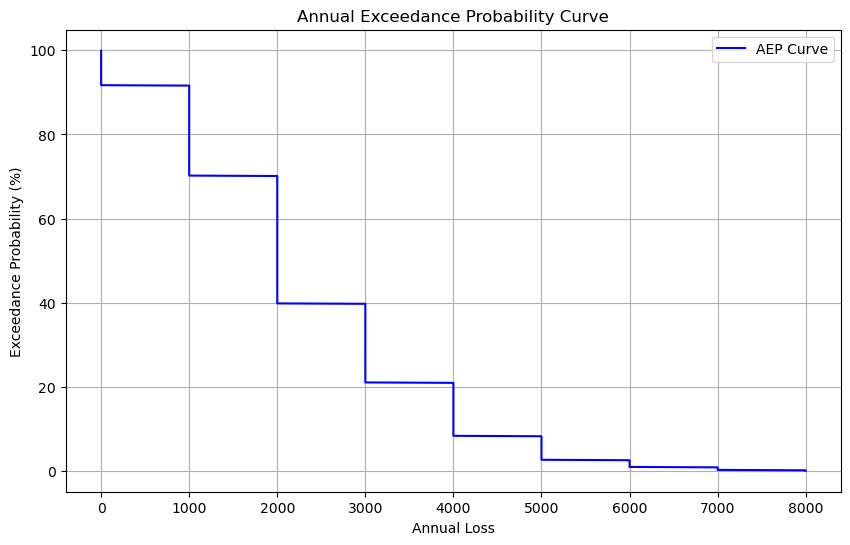


AEP curve data has been saved to 'aep_curve_losses.csv'


In [20]:
# next step, to calculate the AEP curve for the loss
# Calculate AEP curve from yearly losses

# Sort losses in descending order
sorted_losses = yearly_loss_df.sort_values(ascending=False)

# Calculate exceedance probabilities using Weibull plotting position
n = len(sorted_losses)
exceedance_prob = [(i) / (n + 1) * 100 for i in range(1, n + 1)]
return_period = [100 / p for p in exceedance_prob]

# Create AEP curve dataframe
aep_df = pd.DataFrame({
    'Loss': sorted_losses.values,
    'Exceedance_Probability': exceedance_prob,
    'Return_Period': return_period
})

# Display the results
print("\nAEP Curve Summary:")
print(aep_df.head())

# Create AEP curve plot
plt.figure(figsize=(10, 6))
plt.plot(aep_df['Loss'], aep_df['Exceedance_Probability'], 'b-', label='AEP Curve')
plt.grid(True)
plt.ylabel('Exceedance Probability (%)')
plt.xlabel('Annual Loss')
plt.title('Annual Exceedance Probability Curve')
plt.legend()
plt.show()

# Save the AEP curve data
aep_df.to_csv('../outputs/bootstrap_results/aep_curve_losses.csv', index=False)
print("\nAEP curve data has been saved to 'aep_curve_losses.csv'")


In [21]:
## vamos a ver que obtengo con la data observada
df_observed = pd.read_csv('../outputs/tulum_temp_precip_timeseries.csv')

df_observed['event'] = np.where((df_observed['temperature'] > threshold_temperature) & (df_observed['precipitation'] > threshold_precipitation), 1, 0)
df_observed['loss'] = 1000 * df_observed['event']

df_observed['year'] = df_observed['date'].str[:4].astype(int)

yearly_loss_observed = df_observed.groupby('year').sum()



In [22]:
p95_temp = np.percentile(df_observed['temperature'], 95)
p95_precip = np.percentile(df_observed['precipitation'], 95)
print(p95_temp, p95_precip)

30.66119965 0.002975678444999999


In [23]:
yearly_loss_observed.describe()


,temperature,precipitation,event,loss
count,11.000000,11.000000,11.000000,11.000000
mean,9870.580803,0.235215,2.181818,2181.818182
std,1593.940876,0.067227,1.721522,1721.521526
min,5073.004306,0.070186,0.000000,0.000000
25%,10276.699219,0.223187,1.000000,1000.000000
50%,10334.951326,0.236734,2.000000,2000.000000
75%,10403.733006,0.260170,3.500000,3500.000000
max,10499.099811,0.323527,5.000000,5000.000000


In [24]:
# Extract day of year from date column
df_observed['doy'] = pd.to_datetime(df_observed['date']).dt.dayofyear

# Calculate daily climatology (mean temperature for each day of year)
climatology = df_observed.groupby('doy')['temperature'].mean()

# Calculate anomalies by subtracting climatology from actual temperatures
temperature_anomalies = df_observed.apply(lambda x: x['temperature'] - climatology[x['doy']], axis=1)

climatology_precip = df_observed.groupby('doy')['precipitation'].mean()

precipitation_anomalies = df_observed.apply(lambda x: x['precipitation'] - climatology_precip[x['doy']], axis=1)



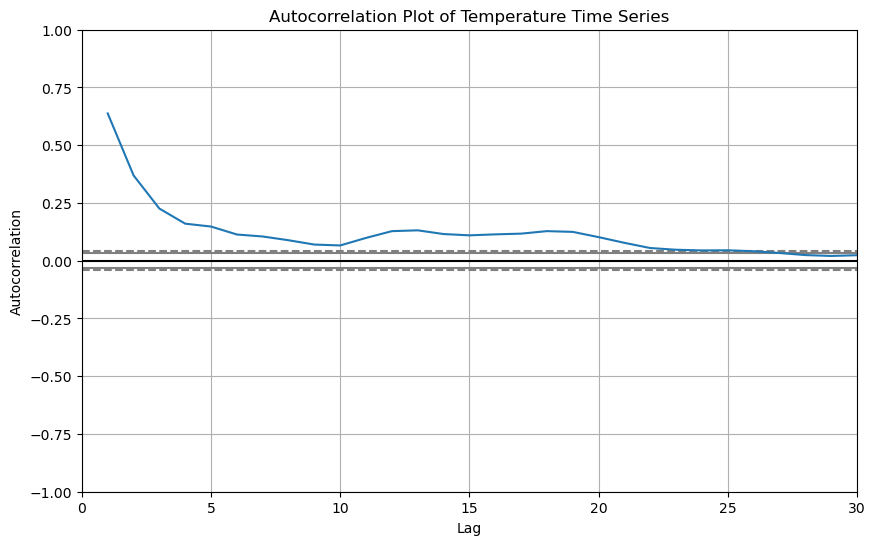

In [16]:
# Create autocorrelation plot
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(temperature_anomalies)
plt.grid(True)
plt.title('Autocorrelation Plot of Temperature Time Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(0, 30)
plt.show()

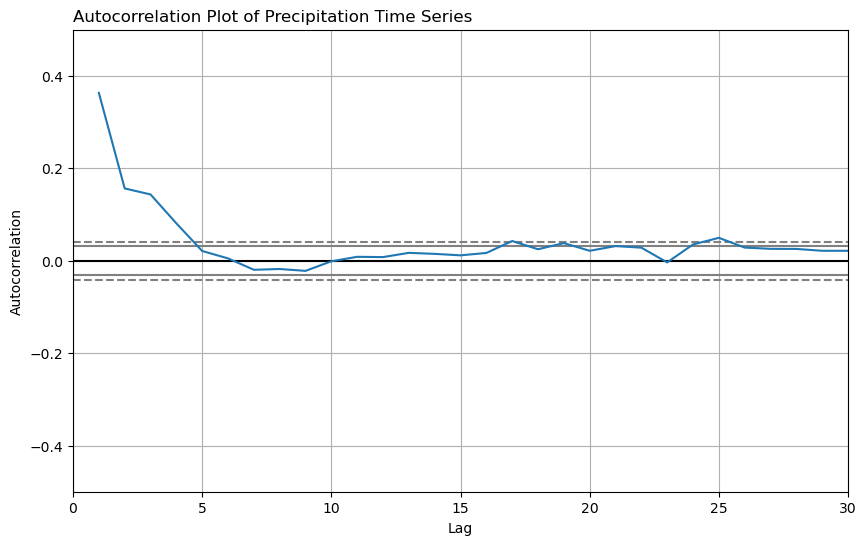

In [28]:
# Create autocorrelation plot
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(precipitation_anomalies)
plt.grid(True)
plt.title('Autocorrelation Plot of Precipitation Time Series', loc='left')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xlim(0, 30)
plt.ylim(-0.5, 0.5)
plt.show()